# Não utilize a biblioteca pandas.
# Não utilize a biblioteca scikit-learn.


# Todas as respostas devem ser justificadas com código.

##### Downloading the [Digits Dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html\#optical-recognition-of-handwritten-digits-dataset)



In [105]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os

# if not os.path.isfile('digits.csv'):
#   !gdown https://drive.google.com/uc?id=1AMxqyx55yqckUmrpvMLDFifPBRqDIX6w

##### O dataset Digits contém imagens, com resolução 8x8, de dígitos manuscritos.

##### Cada linha do CSV possui 65 colunas e corresponde a uma imagem, as 64 primeiras colunas representam cada um dos 8x8 pixels das imagens, enquanto a última coluna corresponde ao dígito representado.

### 1- O dataset possui uma distribuição balanceada de classes? Explique e justifique graficamente a sua resposta.

O dataset está balanceado, pois tem uma pequena variância (6.81) e desvio padrão (2.61)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[178 182 177 183 181 182 181 179 174 180] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


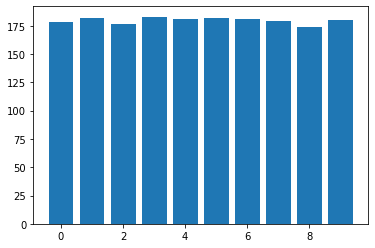

In [106]:
def get_dataset_as_ndarray() -> np.ndarray:
    dataset = np.genfromtxt('./digits.csv', delimiter=',').reshape(-1, 65)
    return dataset


dataset = get_dataset_as_ndarray()
all_labels = dataset[:, -1]
bins, counts = np.unique(all_labels, return_counts=True)
print(
    f'O dataset está balanceado, pois tem uma pequena variância ({counts.var():.2f}) e desvio padrão ({counts.std():.2f})'
)
print(bins)
print(counts, bins)
plt.bar(np.arange(10), counts)
plt.show()

### 2- Exiba uma imagem de cada dígito.

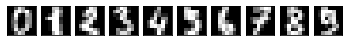

In [107]:
numbers, args = np.unique(all_labels, return_index=True)
fig, ax = plt.subplots(1, 10)
for i in args:
    image = dataset[i, 0:-1].reshape(8, 8)
    ax[i].imshow(image, cmap='gray')
    ax[i].tick_params(left=False,
                      right=False,
                      labelleft=False,
                      labelbottom=False,
                      bottom=False)
plt.show()

### 3- Construa um dataset que contenha apenas os dígitos 0 e 1, separando os dados em arrays de dados e de *labels*.

In [108]:
mask = (all_labels == 0) | (all_labels == 1)
data = dataset[mask, 0:-1]
labels = dataset[mask, -1]
(data.shape, labels.shape)

((360, 64), (360,))

### 4- Quantas imagens possui o dataset que você construiu?

In [109]:
num_images = len(labels)
print(f'O dataset construído possui {num_images} imagens.')

O dataset construído possui 360 imagens.


### 5- Divida o dataset em conjuntos de treino e de teste.
##### Utilize 70% dos dados para treino e 30% para teste.

In [110]:
rng = np.random.default_rng(4)
random_args = np.arange(num_images)
rng.shuffle(random_args)
partition_args = int(0.7 * num_images)
training_x, test_x = data[random_args[:partition_args]], data[
    random_args[partition_args:]]
training_y = labels[random_args[:partition_args]].reshape(-1, 1)
test_y = labels[random_args[partition_args:]].reshape(-1, 1)
training_x.shape, training_y.shape

((251, 64), (251, 1))

### 6- Implemente a função de erro:
$\mathcal{L}(y, y') = -(y\log{(y')} + (1 - y)\log{(1 - y')})$

onde $y$ é a *label* real do dígito, enquanto $y'$ é a saída gerada pelo neurônio.


In [111]:
def loss(y: np.ndarray, p: np.ndarray) -> np.ndarray:
    log = np.log
    eps = np.finfo(p.dtype).eps
    p = np.clip(p, eps, 1 - eps)
    return -(y * log(p) + (1 - y) * log(1 - p))


### 7- Implemente a função de ativação Sigmoide:
$sigmoid(x) = \frac{1}{1 + e^{-x}}$

In [112]:
def sigmoid(x) -> np.ndarray:
    return np.reciprocal((1.0 + np.exp(-x)))


### 8- Implemente um neurônio para a tarefa de regressão, utilizando a função de ativação implementada acima.

In [113]:
class Neuron:

    def __init__(self, weights: np.ndarray, bias: float, learning_rate: float,
                 activation_fn):
        """_summary_

        Args:
            weights (np.ndarray): shape (64, 1)
            bias (float): _description_
            activation_fn (_type_): _description_
        """
        self.weights = weights
        self.bias = bias
        self.activation = activation_fn
        self.learning_rate = learning_rate

    def output(self):
        o = np.sum(self.weights)
        return self.activation(o)

    def forward(self, X: np.ndarray):
        """Computa a passagem pelo neuron

        Args:
            X (np.ndarray): shape = (N, 64)

        Returns:
            float: output sobre todo o conjunto, (N, 1)
        """
        A = X @ self.weights + self.bias
        Y = self.activation(A)
        return Y

    def update_weights(self, gradient):
        self.weights = self.weights - (self.learning_rate * gradient)

### 9- Inicialize os parâmetros do neurônio. Justifique a forma de inicialização escolhida. 

In [114]:
# inicializamos os pesos de forma aleatória para nao haver preferencias
neuron = Neuron(rng.uniform(0, 1, (64, 1)), 0, 1e-4, activation_fn=sigmoid)


### 10- Implemente o cálculo de gradientes dos parâmetros do seu neurônio sabendo que:
$\frac{\partial \mathcal{L}}{\partial w} = \frac{1}{n}X\cdot(A-Y)^T$,

$\frac{\partial \mathcal{L}}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}(a^{(i)}-y^{(i)})$

onde:

$A = sigmoid(w^TX+b)$,

$X$ são os dados de entrada, e

$Y$ são as *labels* correspondentes.


In [115]:
def grad(X: np.ndarray, pred: np.ndarray, y: np.ndarray):
    n = pred.shape[0]
    A = pred - y
    return (X.T @ A) / n



### 11- Implemente o loop de treinamento do neurônio. Defina os hiper parâmetros e explique cada um deles. Treine o modelo e exiba o gráfico do valor de erro ao longo do treinamento.

Loss final: 13.152948049811522.


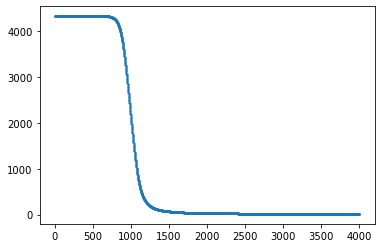

A acurácia foi de 99.08256880733946%
Número de erros: 1.
predição/labels
[[1.00000000e+00]
 [1.00000000e+00]
 [1.14299575e-10]
 [1.00000000e+00]
 [1.00000000e+00]]
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]]
gradients
[[ 0.00000000e+00]
 [-8.29758077e-16]
 [ 2.46091724e-04]
 [ 7.34911263e-02]
 [ 9.93623048e-02]]


In [116]:

# training loop
l = []
for i in range(4000):
    prediction = neuron.forward(training_x)
    gradients = grad(training_x, prediction, training_y)
    neuron.update_weights(gradients)
    l.append(loss(training_y.astype(np.float64), prediction.astype(np.float64)).sum())

# print(l)
print(f"Loss final: {l[-1]}.")
plt.scatter(np.arange(len(l)), l, s=1)
plt.show()

# test
prediction = neuron.forward(test_x)


def classify(prediction) -> np.ndarray:
    return (prediction > 0.5).astype(np.float64)


pred = classify(prediction)
equals = np.sum(pred == test_y)
nerrors = len(pred) - equals
accuracy = equals / len(pred) * 100
print(f"A acurácia foi de {accuracy}%")
print(f"Número de erros: {nerrors}.")

print("predição/labels")
print(prediction[:5])
print(pred[:5])
print(test_y[:5])
print("gradients")
print(gradients[:5])


### 12- Avalie o desempenho do seu modelo. Justifique a sua forma de avaliação. Discuta sobre os resultados.